In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.rcParams['text.usetex'] = True
import illustris_python.groupcat as gc
import sklearn.tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
import halotools.mock_observables

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
MEDIUM_SIZE = 30
SMALL_SIZE = 22
SSSMALL_SIZE = 16

plt.rc('font', size=SSSMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) 

%matplotlib inline

In [2]:
basePath = "/Users/forero/Illustris_data/TNG300-1/"

halo_fields = ['GroupFirstSub', 'Group_M_Crit200', 'Group_R_Crit200', 'Group_M_Mean200',
               'GroupNsubs', 'GroupPos', 'GroupVel', 'GroupFirstSub', 'GroupMassType']
halos = gc.loadHalos(basePath,99, fields=halo_fields) # the selection is based on the FOF groups

subhalo_fields = ['SubhaloMass','SubhaloPos','SubhaloSFRinRad', 'SubhaloVmax','SubhaloMassType','SubhaloVmaxRad',
                  'SubhaloParent', 'SubhaloGrNr', 'SubhaloStellarPhotometrics', 'SubhaloMassInRadType']
subhalos = gc.loadSubhalos(basePath,99, fields=subhalo_fields)
header = gc.loadHeader(basePath,99)
BoxSize = header['BoxSize']
# Photometric bands are: U, B, V, K, g, r, i, z # g-i es [4] - [6]

In [3]:
dtype=[('HaloID', 'i8'),('GalID', 'i8'), ('snapform', 'f8'),('zform', 'f8'),('mass', 'f8'),
       ('x', 'f8'),('y', 'f8'),('z', 'f8')]
central_data = np.loadtxt("/Users/forero/Illustris_data/formation_times_TNG300/301/Galaxies/Central_Galaxies/Central_Galaxies.dat", dtype=dtype)
all_data = np.loadtxt("/Users/forero/Illustris_data/formation_times_TNG300/301/Galaxies/All_Galaxies/ZM_Galaxies3001.dat", dtype=dtype)
sat_data = np.loadtxt("/Users/forero/Illustris_data/formation_times_TNG300/301/Galaxies/Satellite_Galaxies/SatZ_Galaxies.dat", dtype=dtype)

In [70]:
def ratio_color_ssfr_selection(subhalos, log10_stellar_mass, formation_z, gal_id, min_mass, max_mass, plot=False):
    ii = (log10_stellar_mass>min_mass) & (log10_stellar_mass < max_mass)
    bin_formation_z = formation_z[ii]
    bin_gal_id = np.int_(gal_id[ii])
    bin_color = subhalos['SubhaloStellarPhotometrics'][bin_gal_id,4] - subhalos['SubhaloStellarPhotometrics'][bin_gal_id,6]
    bin_sfr = (subhalos['SubhaloSFRinRad'][bin_gal_id]+1E-4)/subhalos['SubhaloMassInRadType'][bin_gal_id, 4]
    bin_pos = subhalos['SubhaloPos'][bin_gal_id]

    z_quartiles = np.percentile(bin_formation_z, [25, 75])
    EARLY=1
    LATE=0
    q_form = np.repeat(2, len(bin_formation_z))
    q_form[bin_formation_z<z_quartiles[0]] = LATE
    q_form[bin_formation_z>z_quartiles[1]] = EARLY
    print('N LATE' , np.count_nonzero(bin_formation_z<z_quartiles[0]))
    print('N EARLY', np.count_nonzero(bin_formation_z>z_quartiles[1]))
    
    X = np.array([bin_color, bin_sfr]).T
    Y = q_form
    print(np.shape(X))

    clf = LinearDiscriminantAnalysis()
    clf.fit(X,Y)
    Y_predict = clf.predict(X)

    early_pos = bin_pos[Y_predict==EARLY, :]
    late_pos = bin_pos[Y_predict==LATE, :]
    all_pos = bin_pos.copy()

    if plot:
        plt.figure(figsize=(12,5))
        #plt.subplot(1,2,1)
        #plt.scatter(bin_color[q_form==0], np.log10(bin_sfr[q_form==0]), s=0.1)
        #plt.scatter(bin_color[q_form==1], np.log10(bin_sfr[q_form==1]), s=0.1)

        plt.subplot(1,2,1)
        #plt.scatter(bin_color[bin_formation_z<z_quartiles[0]], 
        #            np.log10(bin_sfr[bin_formation_z<z_quartiles[0]]), s=0.1, label='LATE')
        plt.hist(np.log10(bin_sfr[bin_formation_z<z_quartiles[0]]))
        print(np.count_nonzero(bin_color[bin_formation_z<z_quartiles[0]]))
        plt.xlabel('color (g-r)')
        plt.ylabel('log SFR')
        plt.legend()
        
        plt.subplot(1,2,2)
        #plt.scatter(bin_color[bin_formation_z>z_quartiles[1]], 
        #            np.log10(bin_sfr[bin_formation_z>z_quartiles[1]]), s=0.1, label='EARLY')
        plt.hist(np.log10(bin_sfr[bin_formation_z>z_quartiles[1]]))
        print(np.count_nonzero(bin_color[bin_formation_z>z_quartiles[1]]))
        #plt.scatter(bin_color, np.log10(bin_sfr), s=0.1, c=bin_formation_z, label='ALL')

        #plt.scatter(bin_color[Y_predict==LATE], np.log10(bin_sfr[Y_predict==LATE]), s=0.1,label='Late Assembly')
        #plt.scatter(bin_color[Y_predict==1], np.log10(bin_sfr[Y_predict==1]), s=0.1)
        #plt.scatter(bin_color[Y_predict==EARLY], np.log10(bin_sfr[Y_predict==EARLY]), s=0.1, label='Early Assembly')
        plt.xlabel('color (g-r)')
        plt.ylabel('log SFR')
        plt.legend()
        
    corr = {}
    r = np.linspace(5000.0, 10000.0,10)
    corr['early'] = halotools.mock_observables.tpcf(early_pos, r, period=205000.0, estimator='Landy-Szalay')
    corr['late'] = halotools.mock_observables.tpcf(late_pos, r, period=205000.0, estimator='Landy-Szalay')
    corr['all'] = halotools.mock_observables.tpcf(all_pos, r, period=205000.0, estimator='Landy-Szalay')
    corr['r'] = 0.5*(r[1:]+r[:-1])


    ratio_late_mean = np.mean((corr['late']/corr['all']))
    ratio_late_std = np.std((corr['late']/corr['all']))
    ratio_early_mean = np.mean((corr['early']/corr['all']))
    ratio_early_std = np.std((corr['early']/corr['all']))
    return {'ratio_late_mean':ratio_late_mean, 'ratio_late_std':ratio_late_std, 
            'ratio_early_mean':ratio_early_mean, 'ratio_early_std':ratio_early_std}

In [71]:
def compute_ratio(subhalos, log10_stellar_mass, formation_z, gal_id):
    log_mass_bins = np.arange(9.0, 11.5, 0.25)
    ratio_late_mean = np.ones(len(log_mass_bins))
    ratio_late_std = ratio_late_mean.copy()
    ratio_early_mean = ratio_late_mean.copy()
    ratio_early_std = ratio_late_mean.copy()

    for i, min_mass_bin in enumerate(log_mass_bins):
        r = ratio_color_ssfr_selection(subhalos, log10_stellar_mass, formation_z, gal_id, min_mass_bin, min_mass_bin+0.5)
        ratio_late_mean[i] = r['ratio_late_mean']
        ratio_late_std[i] = r['ratio_late_std']
        ratio_early_mean[i] = r['ratio_early_mean']
        ratio_early_std[i] = r['ratio_early_std']
    return {'log_mass_bins':log_mass_bins, 
            'ratio_late_mean':ratio_late_mean, 'ratio_late_std':ratio_late_std,
            'ratio_early_mean':ratio_early_mean, 'ratio_early_std':ratio_early_std}

In [58]:
formation_z = all_data['zform']
gal_id = all_data['GalID']
log10_stellar_mass = np.log10(all_data['mass'])+10
ratio_all = compute_ratio(subhalos, log10_stellar_mass, formation_z, gal_id)

N LATE 20662
N EARLY 20873
(88583, 2)
N LATE 18274
N EARLY 18447
(76791, 2)
N LATE 16099
N EARLY 15184
(65364, 2)
N LATE 13332
N EARLY 13970
(57236, 2)
N LATE 11332
N EARLY 11405
(48917, 2)
N LATE 7035
N EARLY 6890
(30313, 2)
N LATE 2954
N EARLY 3056
(12494, 2)
N LATE 1249
N EARLY 1288
(5195, 2)
N LATE 549
N EARLY 502
(2248, 2)
N LATE 211
N EARLY 230
(948, 2)


In [59]:
formation_z_central = central_data['zform']
gal_id_central = central_data['GalID']
log10_stellar_mass_central = np.log10(central_data['mass'])+10
ratio_central = compute_ratio(subhalos, log10_stellar_mass_central, formation_z_central, gal_id_central)

N LATE 11189
N EARLY 11729
(49570, 2)
N LATE 10211
N EARLY 10681
(43428, 2)
N LATE 9421
N EARLY 9286
(37817, 2)
N LATE 7841
N EARLY 8139
(34094, 2)
N LATE 7019
N EARLY 7172
(29971, 2)
N LATE 4472
N EARLY 4621
(19386, 2)
N LATE 2170
N EARLY 2078
(8714, 2)
N LATE 939
N EARLY 951
(3933, 2)
N LATE 436
N EARLY 430
(1835, 2)
N LATE 190
N EARLY 201
(829, 2)


No handles with labels found to put in legend.
No handles with labels found to put in legend.


N LATE 6680
N EARLY 6173
(27470, 2)
6680
6173


{'ratio_early_mean': 2.312371273582723,
 'ratio_early_std': 0.09975977113120459,
 'ratio_late_mean': 0.4736261472672684,
 'ratio_late_std': 0.08242896801684733}

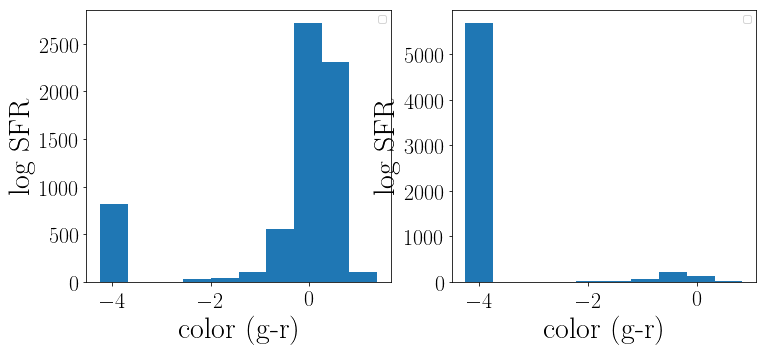

In [72]:
ratio_color_ssfr_selection(subhalos, log10_stellar_mass, formation_z, gal_id, 10.00, 10.25, plot=True)

(17477, 2)


{'ratio_early_mean': 2.4598295884562327,
 'ratio_early_std': 0.4508770127699104,
 'ratio_late_mean': 0.5582720432050166,
 'ratio_late_std': 0.4267824652460164}

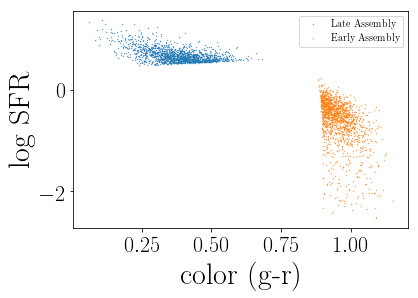

In [25]:
ratio_color_ssfr_selection(subhalos, log10_stellar_mass_central, formation_z_central, gal_id_central, 9.75, 10.0, plot=True)

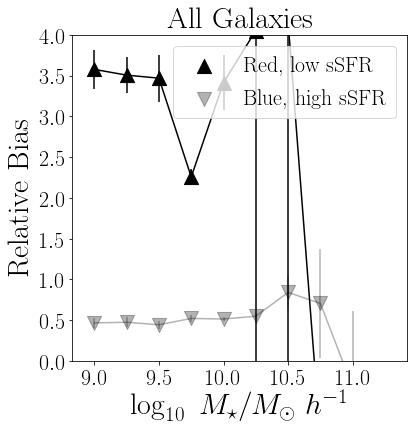

In [28]:
plt.figure(figsize=(6,6))
plt.scatter(ratio_all['log_mass_bins'], ratio_all['ratio_early_mean'], marker='^', s=200, color='black', label='Red, low sSFR')
plt.errorbar(ratio_all['log_mass_bins'], ratio_all['ratio_early_mean'], ratio_all['ratio_early_std'], color='black')
plt.scatter(ratio_all['log_mass_bins'], ratio_all['ratio_late_mean'], marker='v', s=200, color='black', alpha=0.3, label='Blue, high sSFR')
plt.errorbar(ratio_all['log_mass_bins'], ratio_all['ratio_late_mean'], ratio_all['ratio_late_std'], color='black', alpha=0.3)

plt.title('All Galaxies')
plt.ylim([0, 4.0])
plt.xlabel("$\log_{10}\ M_{\mathrm{\star}} / M_{\odot}\ h^{-1}$")
plt.ylabel("Relative Bias")
plt.xticks(np.arange(9.0, 11.5, 0.5))
plt.yticks(np.arange(0.0, 4.5, 0.5))
plt.legend(fontsize=SMALL_SIZE, loc=0)

plt.savefig("bias_galaxies_mag_sfr_cuts.pdf", bbox_inches='tight')